# Lagrangian Tesselation and simple Analysis for Dark Matter Simulations

We will code up a few pedagogical examples of how to use the way of thinking about of N-body simulations described in <a href="http://arxiv.org/abs/1111.3944">Abel, Hahn & Kaehler (2012)</a>. We show here <b>how easy</b> it is but do not spend time on optimizing. Our steps today are:
<li> Use <a href="yt-project.org"><it>yt</it></a> to read in data from a <a href="http://www.mpa-garching.mpg.de/gadget/">Gadget</a> simulation 
<li> Create a density field as described in <a href="http://arxiv.org/abs/1210.6652">Hahn, Abel & Kaehler (2013)</a>
<li> Grid the density onto a Cartesian mesh
<li> give further pointers to the literature for improvements and optimization tips.
</li>

Hack ideas:
<li> Use hope or another python jit compiler to get performance
<li> Measure a velocity distribution function at a single point
<li> Grid the Mass weighted average velocity to study bulk flow
<li> Try this in Julia and check the speed up
<li> Your idea here! 

In [1]:
import matplotlib.pylab as plt
import numpy as np
import yt

In [52]:
ds = yt.load("./snapshot_010")
#ds = yt.load("/Users/tabel/Research/OldResearch/TetraPart/data/32^3/snapshot_000")
dd = ds.all_data() # select the entire simulation region

yt : [INFO     ] 2023-01-17 17:23:14,782 Calculating time from 1.000e+00 to be 4.331e+17 seconds
yt : [INFO     ] 2023-01-17 17:23:14,784 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2023-01-17 17:23:14,881 Parameters: current_time              = 4.330897016329948e+17 s
yt : [INFO     ] 2023-01-17 17:23:14,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-01-17 17:23:14,885 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-17 17:23:14,887 Parameters: domain_right_edge         = [40. 40. 40.]
yt : [INFO     ] 2023-01-17 17:23:14,887 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-01-17 17:23:14,888 Parameters: current_redshift          = -2.220446049250313e-16
yt : [INFO     ] 2023-01-17 17:23:14,889 Parameters: omega_lambda              = 0.724
yt : [INFO     ] 2023-01-17 17:23:14,889 Parameters: omega_matter              = 0.276
yt : [INFO     ] 2023-01-17 17:23:14,890 Parameters: omega_radiation      

In [53]:
ds.field_list

[('Halo', 'Coordinates'),
 ('Halo', 'Mass'),
 ('Halo', 'ParticleIDs'),
 ('Halo', 'Velocities'),
 ('all', 'Coordinates'),
 ('all', 'Mass'),
 ('all', 'ParticleIDs'),
 ('all', 'Velocities'),
 ('nbody', 'Coordinates'),
 ('nbody', 'Mass'),
 ('nbody', 'ParticleIDs'),
 ('nbody', 'Velocities')]

In [54]:
dd.get_data(fields=('nbody','Coordinates'))
dd.get_data(fields=('nbody','Velocities'))
dd.get_data(fields=('nbody','ParticleIDs'))

In [55]:
p = dd.field_data[('nbody','Coordinates')].to_ndarray()
v = dd.field_data[('nbody','Velocities')].to_ndarray()
id = dd.field_data[('nbody','ParticleIDs')].to_ndarray()
ind = np.argsort(id) # sort particles by their IDs (not strictly necessary but we can save memory)
p = p[ind,:]
v = v[ind,:]
id = 0

In [56]:
Np = len(p[:,0])  # check. All particles are loaded.
print(Np)

262144


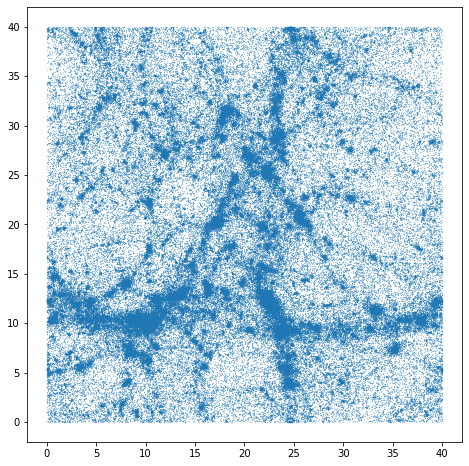

In [57]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(p[0:,0],p[0:,1],'.',markersize=.3);

39.6875

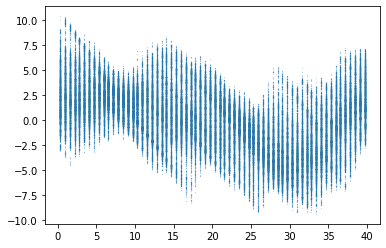

In [58]:
def index1D(Ndim,i,j,k):
    return (i*Ndim + j)*Ndim + k

bext = (ds.domain_right_edge-ds.domain_left_edge).to_ndarray() # extent of box
Ndim = np.int64(Np**.333333334)
x = bext[0]*(0.5+np.arange(Ndim))/(Ndim)
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
# equivalent to:
#for i in xrange(Ndim):
#    for j in xrange(Ndim):
#        for k in xrange(Ndim):
#            ind = index1D(Ndim,i,j,k)
#            xl[ind] = x[i] 
#            yl[ind] = x[j] 
#            zl[ind] = x[k] 

dx = (p[:,0]-xl)
dy = (p[:,1]-yl)
dz = (p[:,2]-zl)
dis = np.sqrt(dx**2+dy**2+dz**2) # Lagrangian displacement
(p[:,0])[dx < -20.] += bext[0]
(p[:,1])[dy < -20.] += bext[1]
(p[:,2])[dz < -20.] += bext[2]
(p[:,0])[dx >  20.] -= bext[0]
(p[:,1])[dy >  20.] -= bext[1]
(p[:,2])[dz >  20.] -= bext[2]
dx = (p[:,0]-xl)
dy = (p[:,1]-yl)
dz = (p[:,2]-zl)
dis = np.sqrt(dx**2+dy**2+dz**2) # Lagrangian displacement

# Useful for debugging:
#p[:,0] = xl
#p[:,1] = yl
#p[:,2] = zl

plt.plot(xl,dx,'.',markersize=.2)
xl.max()

In [59]:
p3d = p.reshape(Ndim,Ndim,Ndim,3)  # reshape the array so we have the Lagrangian coordinates in 3D
# This next step reverses the xyz ordering to zyx ordering and go from C to fortran order and vice versa
# One should read in the initial conditions of a simulation and check that all tetrahedra volumes 
# come out positive. If they are all negative comment out this next line and try again.
p3d = p3d[:,:,:,::-1] 

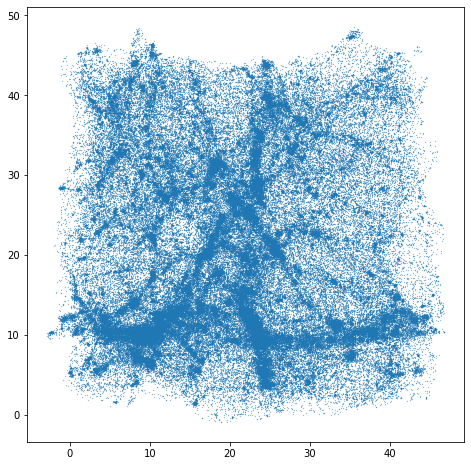

In [60]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(p[0:,0],p[0:,1],'.',markersize=.4);

We need two lists to define the 6 tetrahedra that make up the unit cube. 
<img src="https://raw.githubusercontent.com/yipihey/LagrangianPhaseSpaceSheetEasy/ba4fee799fb59d282482ac6cc8d04c2dcb732782/Figure3.png?token=GHSAT0AAAAAABS4N6WJGM4E35AMOBXPMR3WYT3V3WA" width=400 align="right">

In [61]:
# here are the two lines that define our tetrahedra
vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
conn = np.array( ( (4,0,7,1), (1,0,7,3), (5,1,4,7), (2,3,1,7), (1,5,6,7), (2,6,7,1) ))


In [62]:
def get_tet_centroids(Ndim,p3d):
    """ A fast function to compute the centroids of all tetrahedra """
    vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
    conn = np.array( ( (4,0,7,1), (1,0,7,3), (5,1,4,7), (2,3,1,7), (1,5,6,7), (2,6,7,1) ))
    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    cen = np.zeros((Np*Ntetpp,3))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        orig = p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - orig ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - orig ).reshape((Np,3))
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - orig).reshape((Np,3))   
        cen[m::Ntetpp,:] = orig.reshape(Np,3) + ((a+b+c)/4.)
    return cen

def get_voxel_volumes(Ndim,p3d):
    """Using the 6tetrahedra per voxel calculate their total volume. 
       I.e. it computes the volumes of all tetrahedra and sums them for each voxel"""
    vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
    conn = np.array( ( (4,0,7,1), (1,0,7,3), (5,1,4,7), (2,3,1,7), (1,5,6,7), (2,6,7,1) ))

    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    vol = np.zeros((Ndim,Ndim,Ndim))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))        
        b = np.cross(b,c)
        vol[:,:,:] += (np.sum(a*b,axis=1)/6.).reshape((Ndim,Ndim,Ndim))
    return vol

def get_tet_volumes(Ndim,p3d):
    """A fast function to compute the volumes of all tetrahedra"""
    vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
    conn = np.array( ( (4,0,7,1), (1,0,7,3), (5,1,4,7), (2,3,1,7), (1,5,6,7), (2,6,7,1) ))

    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    vol = np.zeros((Ndim,Ndim,Ndim, Ntetpp))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))        
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ).reshape((Np,3))
        b = np.cross(b,c)
        vol[:,:,:,m] = (np.sum(a*b,axis=1)/6.).reshape((Ndim,Ndim,Ndim))
    return vol

voxvol = get_voxel_volumes(Ndim-1,p3d)
vol = get_tet_volumes(Ndim-1,p3d)
cen = get_tet_centroids(Ndim-1,p3d)

In [63]:
# Test on uniform lattice
l1d = np.linspace(0,4,100)
x,y,z = np.meshgrid(l1d,l1d,l1d)
pt = np.zeros((100,100,100,3))
pt[:,:,:,0] = x
pt[:,:,:,1] = y
pt[:,:,:,2] = z
tvol = get_tet_volumes(99,pt)
print(tvol.sum()) # should evaluate to 64 



63.99999999999926


Let's plot it as particles assuming the mass is not at the particles but as the center of the tetrahedra

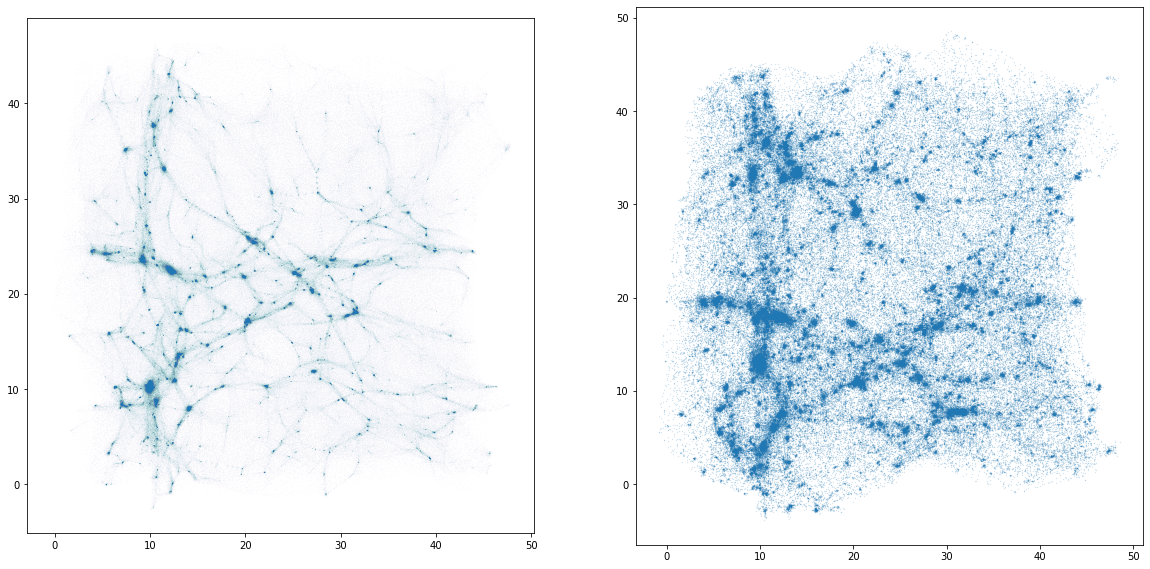

In [64]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, aspect='equal')
ax.plot(cen[:,1],cen[:,2],'.',markersize=.5,alpha=.01);
ax = fig.add_subplot(122, aspect='equal')
ax.plot(p[:,1],p[:,2],'.',markersize=.5,alpha=.3);

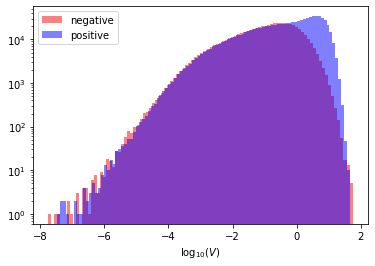

In [90]:
# show the single stream region that is the voids as the regions with positive volume
mnvol = -(vol[vol<0].flatten())/(np.prod(bext)/Ndim**3)*6 # every particle in ICs has volume of 1 this way 
mpvol = vol[vol > 0].flatten()/(np.prod(bext)/Ndim**3)*6
#mvoxvol = np.fabs(voxvol.flatten())/(np.prod(bext)/Ndim**3) # every particle in ICs has volume of 1 this way 
b = plt.hist(np.log10(mnvol+1e-32),bins=100,log=True,alpha=0.5,color="red",label="negative")
vb = plt.hist(np.log10(mpvol+1e-32),bins=100,log=True,alpha=0.5,color="blue",label="positive")
plt.xlabel(r"$\log_{10}(V)$")
plt.legend();

In [83]:
vol.sum()/np.prod(bext) * 64**3/63**3

0.9901618256623204

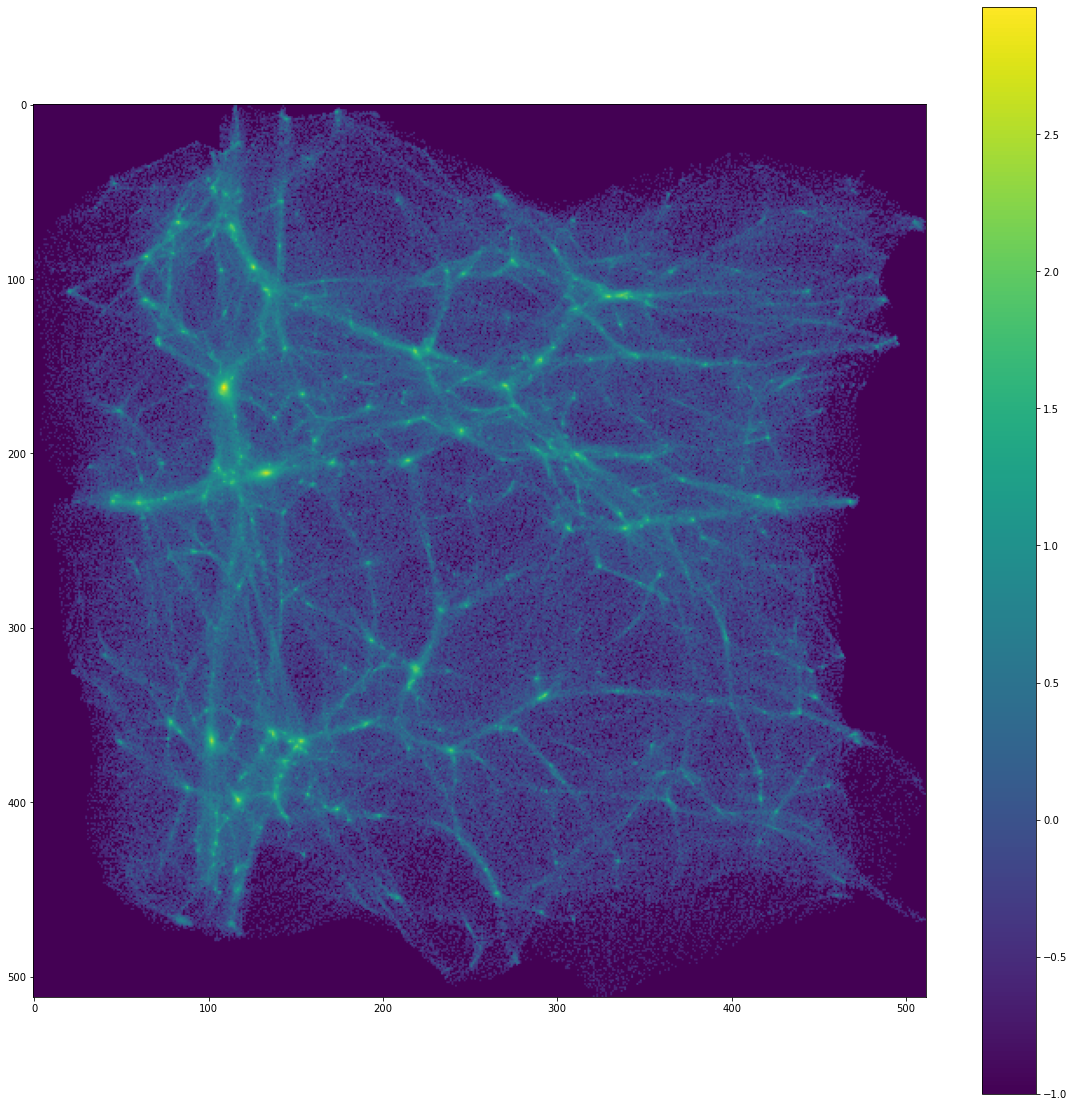

In [67]:
H, edges = np.histogramdd([cen[:,0],cen[:,1]],bins=(8*Ndim,8*Ndim))
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log10(H/6.+1e-1))
plt.colorbar();

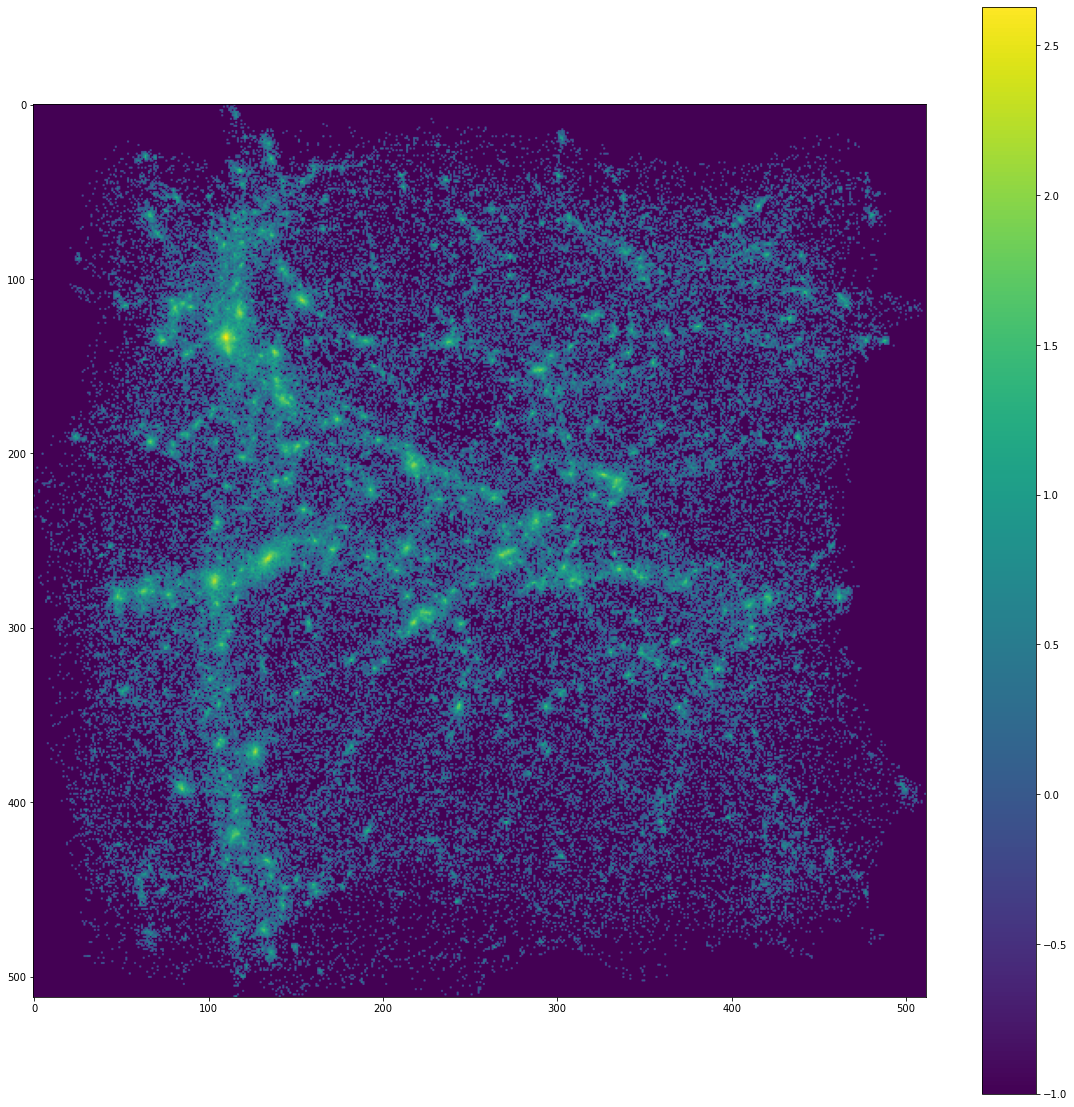

In [68]:
fig = plt.figure(figsize=(20,20))
H, edges = np.histogramdd([p[:,0],p[:,1]],bins=(8*Ndim,8*Ndim))
plt.imshow(np.log10(H+1e-1))
plt.colorbar();

Each tetahedron also can be seen as the linear transformation that transform the initial cartesian tetrahedron to the final position.

In [69]:
def get_tet_interpolated_particles(Ndim,p3d, split=10):
    """ A fast function to create particles inside tetrahedra 
        with the same linear map that made the tet. """
    vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
    conn = np.array( ( (4,0,7,1), (1,0,3,7), (5,1,4,7), (2,3,7,1), (1,5,6,7), (2,6,1,7) ))
    Ntetpp = len(conn)
    Nnppp  = Ntetpp*split
    Np = Ndim*Ndim*Ndim
    newp = np.zeros((Np*Nnppp,3))
    ro = np.random.random(size=(Np*Nnppp,3)) # random offsets
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        orig = p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - orig ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - orig ).reshape((Np,3))
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - orig).reshape((Np,3))
        for s in range(split):
            for i in range(3):
                newp[m+s::Nnppp,i] = orig.reshape(Np,3)[:,i] + \
                    ((ro[m+s::Nnppp,0]*a[:,i]+ro[m+s::Nnppp,1]*b[:,i]+ro[m+s::Nnppp,2]*c[:,i]))
    return newp


Now split each tetrahedron into 100 particles

In [70]:
newp = get_tet_interpolated_particles(Ndim-1,p3d, split=100)

In [71]:
H, edges = np.histogramdd([newp[:,0],newp[:,1]],bins=(8*Ndim,8*Ndim))

/var/folders/8h/csrqy1dd1x1d93qvzyh33kn40000gn/T/ipykernel_73936/1895441940.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(H/H.mean()+H[H > 1.1*H.min()].min()-1),vmax=2.3,cmap="bwr")


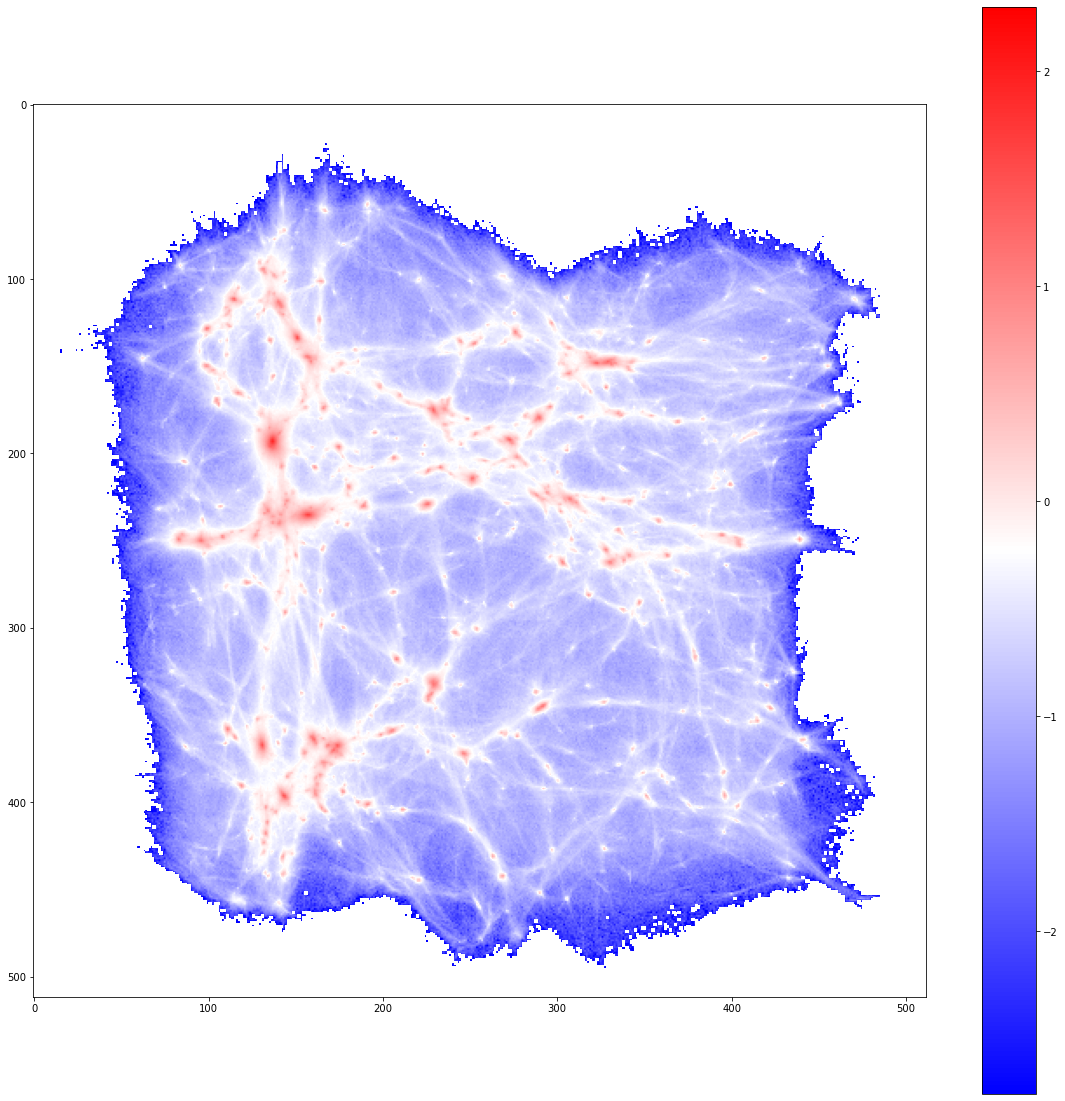

In [89]:
fig = plt.figure(figsize=(20,20))
plt.imshow(np.log10(H/H.mean()+H[H > 1.1*H.min()].min()-1),vmax=2.3,cmap="bwr")

plt.colorbar();

In [25]:
import numpy as np
import PSI as psi
import helpers as hlp

snap = "./snapshot_010"
mesh = psi.Mesh(filename=snap, loader='gadget2')
# create the Grid, specifying the resolution and projection window
ngrid = (128,128,1)
win = (mesh.boxmin, mesh.boxmax)
print(win)
grid = psi.Grid(type="cart", n=ngrid, window=win)
print("type:", grid.type)
#psi.voxels(grid=grid, mesh=mesh, mode='density')

# check the total mass
# show a picture
elemmass = np.sum(mesh.mass)
voxmass = np.sum(grid.fields["m"])
err = np.abs(1.0-voxmass/elemmass)

# print the error and show the figure
print('Global error = %.10e' % err)
hlp.makeFigs(grid.fields['m'], log=True, title='Example 2: Voxelization of a cosmological density field')

: 

: 

## Alternatively we can use Fourier interpolation to upsample our particle field